***Import Needed Libs***

In [1]:
import os
from PIL import Image
import itertools

import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, Activation, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')

print('Modules Loaded')

2024-08-18 21:33:18.110030: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-18 21:33:18.110159: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-18 21:33:18.229725: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Modules Loaded


***Preprocessing Train Dataset***

In [2]:
train_data_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'
filepaths = []
labels = []

folds = os.listdir(train_data_path)
for fold in folds:
    foldpath = os.path.join(train_data_path, fold)
    filelist = os.listdir(foldpath)
    
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)
        
FSeries = pd.Series(filepaths, name='filepaths')
LSeries = pd.Series(labels, name='label')

df = pd.concat([FSeries, LSeries], axis=1)

In [3]:
df

,filepaths,label
0,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
1,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
2,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
3,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
4,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
...,...,...
5211,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
5212,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
5213,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
5214,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL


***Preprocessing Valid Dataset***

In [4]:
valid_data_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/val'
filepaths = []
labels = []

folds = os.listdir(valid_data_dir)
for fold in folds:
    foldpath = os.path.join(valid_data_dir, fold)
    filelist = os.listdir(foldpath)
    
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)
        
FSeries = pd.Series(filepaths, name='filepaths')
LSeries = pd.Series(labels, name='label')

valid = pd.concat([FSeries, LSeries], axis=1)

In [5]:
valid

,filepaths,label
0,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
1,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
2,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
3,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
4,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
5,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
6,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
7,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
8,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
9,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL


***Preprocessing Test Dataset***

In [6]:
test_data_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test'
filepaths = []
labels = []

folds = os.listdir(test_data_dir)

for fold in folds:
    foldpath = os.path.join(test_data_dir, fold)
    filelist = os.listdir(foldpath)
    
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)
        
FSeries = pd.Series(filepaths, name='filepaths')
LSeries = pd.Series(labels, name='label')

test = pd.concat([FSeries, LSeries], axis=1)

In [7]:
test

,filepaths,label
0,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
1,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
2,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
3,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
4,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
...,...,...
619,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
620,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
621,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
622,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL


***Spliting Data Into Train, Valid, Test***

In [8]:
train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=42)
valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=42)

***ImageDataGenerator***

In [9]:
# crobed image size
batch_size = 16
img_size = (224, 224)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()
val_gen= ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'label', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = val_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'label', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'label', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 4172 validated image filenames belonging to 2 classes.
Found 522 validated image filenames belonging to 2 classes.
Found 522 validated image filenames belonging to 2 classes.


***Showing Sample From Data***

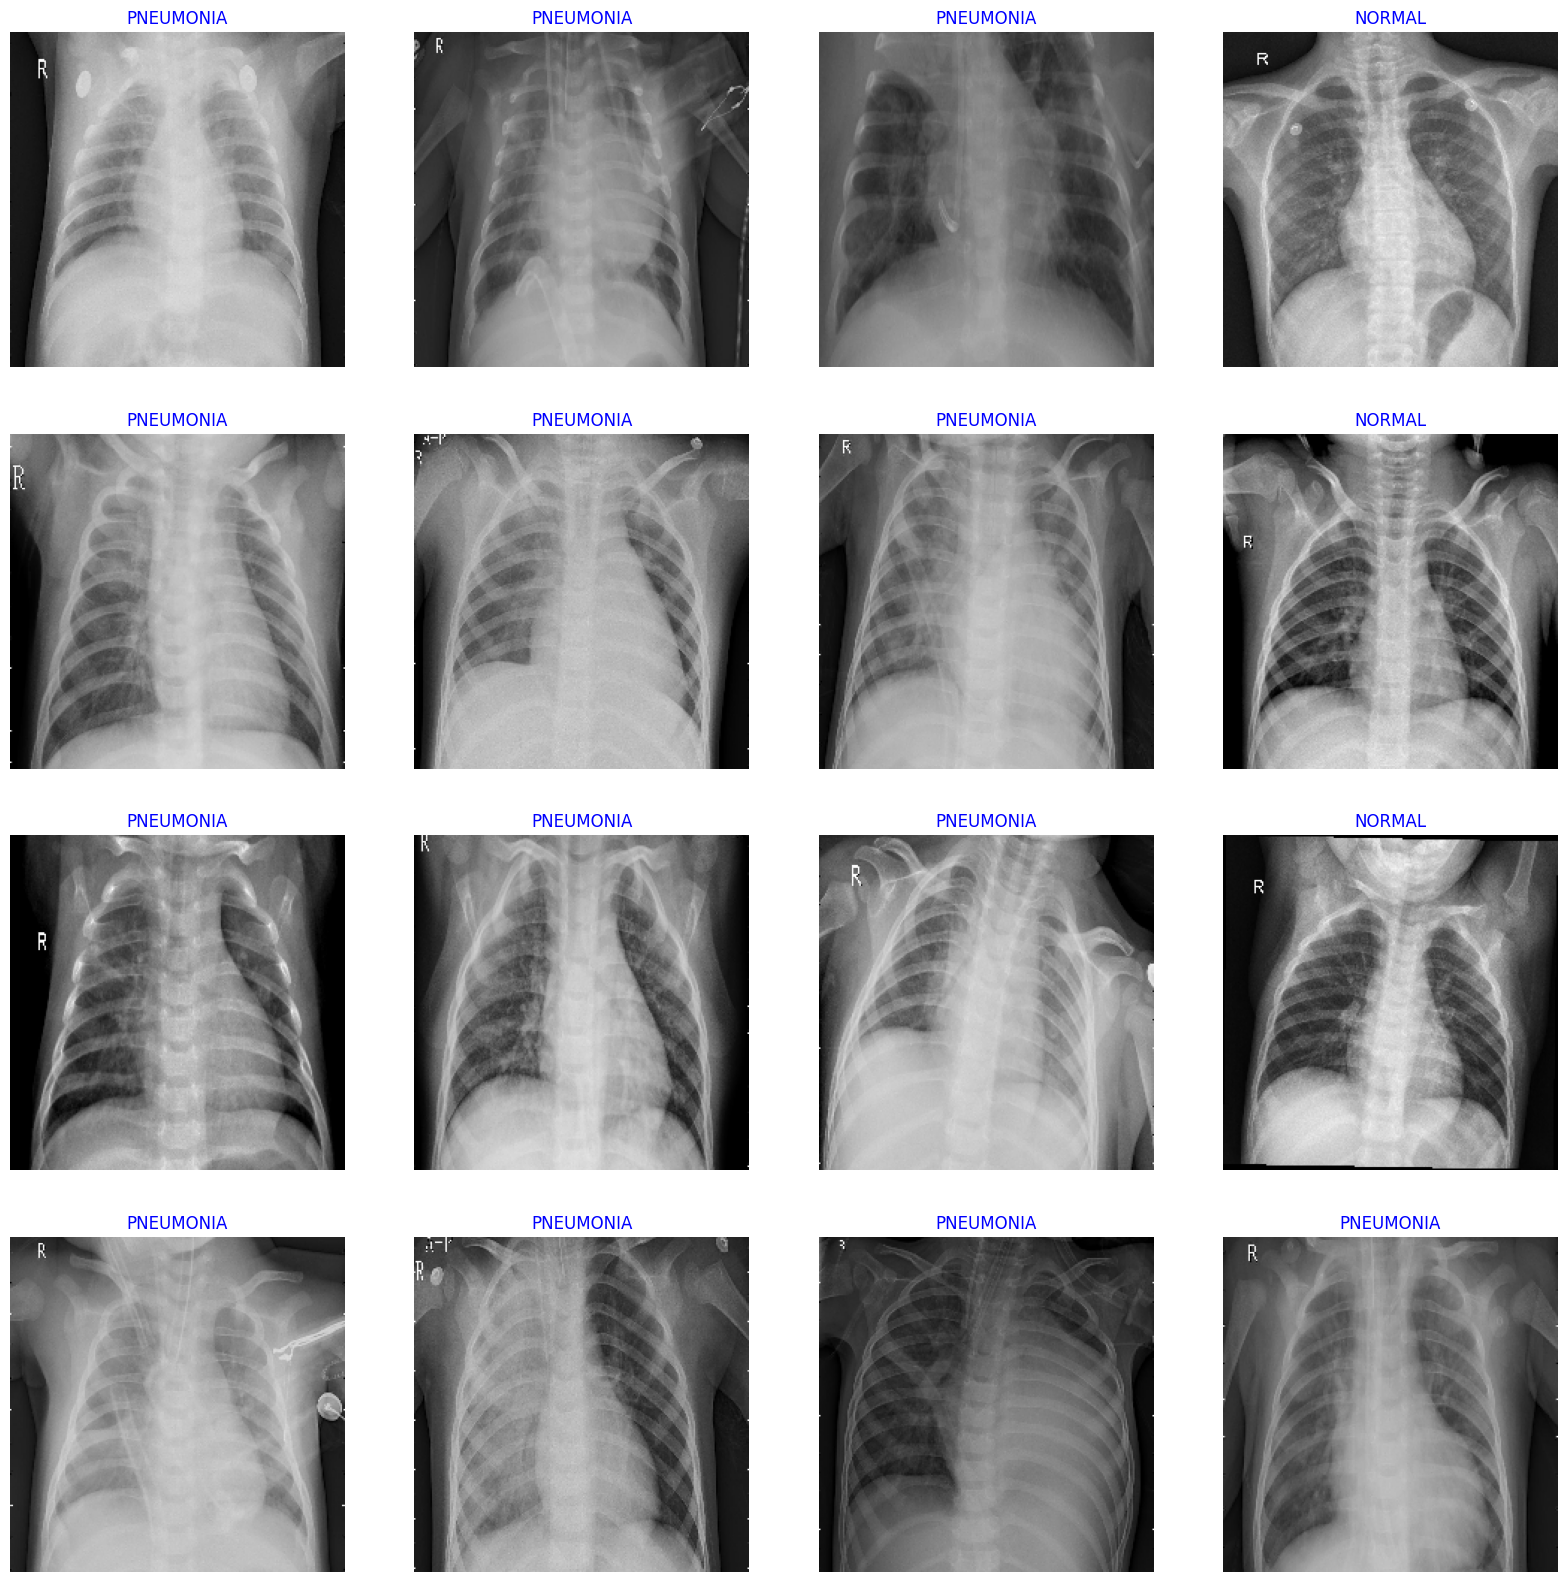

In [10]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images , labels = next(train_gen)

plt.figure(figsize= (20,20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color = 'blue' , fontsize= 12)
    plt.axis('off')
plt.show();

***Model Structure***

In [11]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

model = Sequential([
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape),
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    
    Dense(256,activation = "relu"),
    Dense(64,activation = "relu"),
    Dense(class_count, activation = "softmax")
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 128)       0         
 g2D)                                                   

### Training The Data

In [12]:
epochs = 13   # number of all epochs in training

history = model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/13


I0000 00:00:1724016826.284326      70 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


261/261 [==============================] - 84s 276ms/step - loss: 8.3554 - accuracy: 0.8018 - val_loss: 417.7591 - val_accuracy: 0.9176
Epoch 2/13
261/261 [==============================] - 42s 162ms/step - loss: 0.1650 - accuracy: 0.9389 - val_loss: 1115.4788 - val_accuracy: 0.9100
Epoch 3/13
261/261 [==============================] - 42s 160ms/step - loss: 0.1302 - accuracy: 0.9566 - val_loss: 2037.0338 - val_accuracy: 0.9444
Epoch 4/13
261/261 [==============================] - 42s 162ms/step - loss: 0.1133 - accuracy: 0.9590 - val_loss: 4306.6445 - val_accuracy: 0.9521
Epoch 5/13
261/261 [==============================] - 41s 157ms/step - loss: 0.0804 - accuracy: 0.9717 - val_loss: 2006.7236 - val_accuracy: 0.9636
Epoch 6/13
261/261 [==============================] - 41s 156ms/step - loss: 0.0896 - accuracy: 0.9676 - val_loss: 1639.9694 - val_accuracy: 0.9617
Epoch 7/13
261/261 [==============================] - 43s 163ms/step - loss: 0.0838 - accuracy: 0.9700 - val_loss: 2475.5022

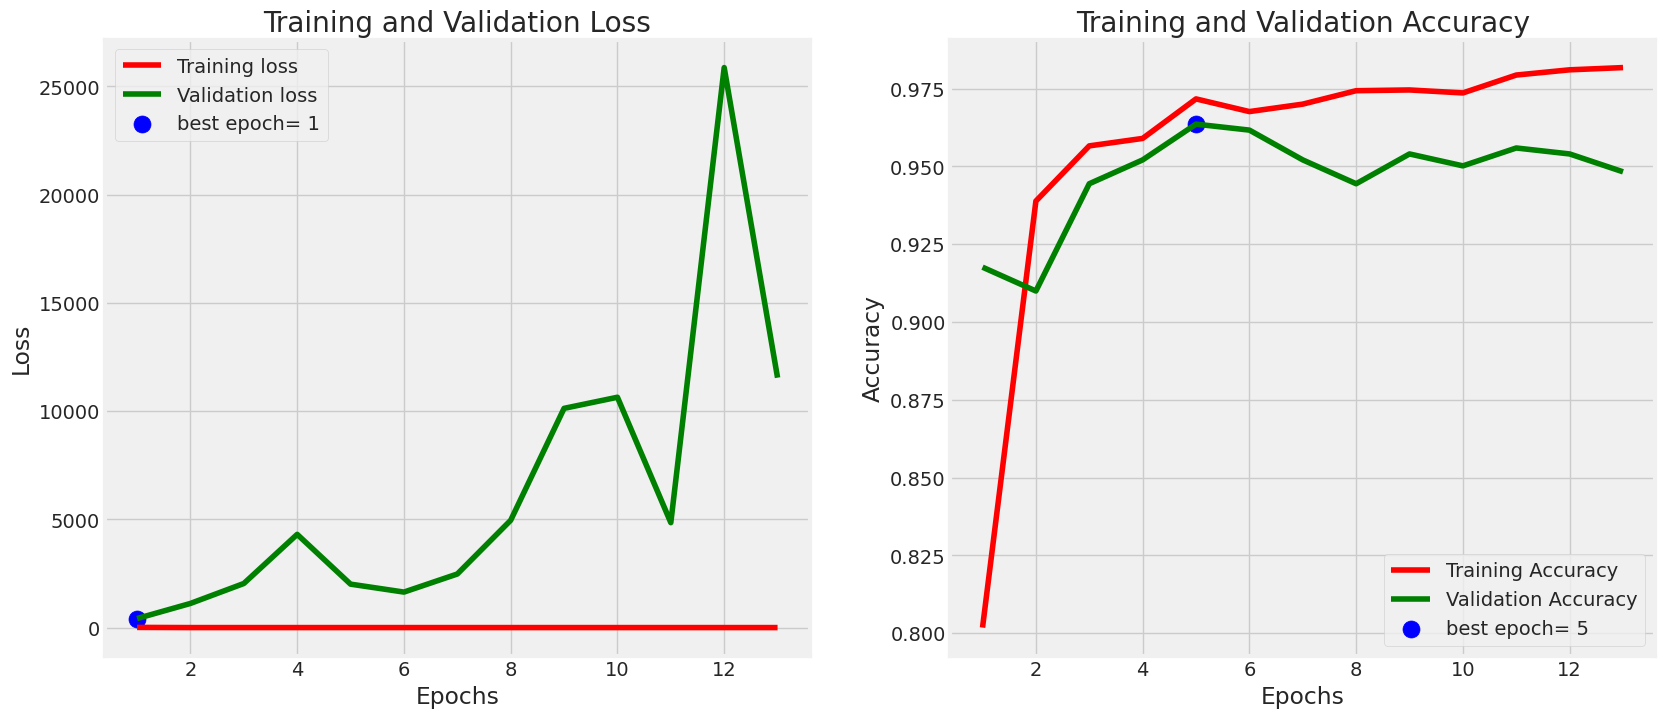

In [13]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

### Model Evaluation

In [14]:
train_score = model.evaluate(train_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

33/33 [==============================] - 7s 217ms/step - loss: 7805.0327 - accuracy: 0.9540
Train Loss:  0.03992905095219612
Train Accuracy:  0.9827420711517334
--------------------
Validation Loss:  8080.0029296875
Validation Accuracy:  0.954023003578186
--------------------
Test Loss:  7805.03271484375
Test Accuracy:  0.954023003578186


In [15]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1) 

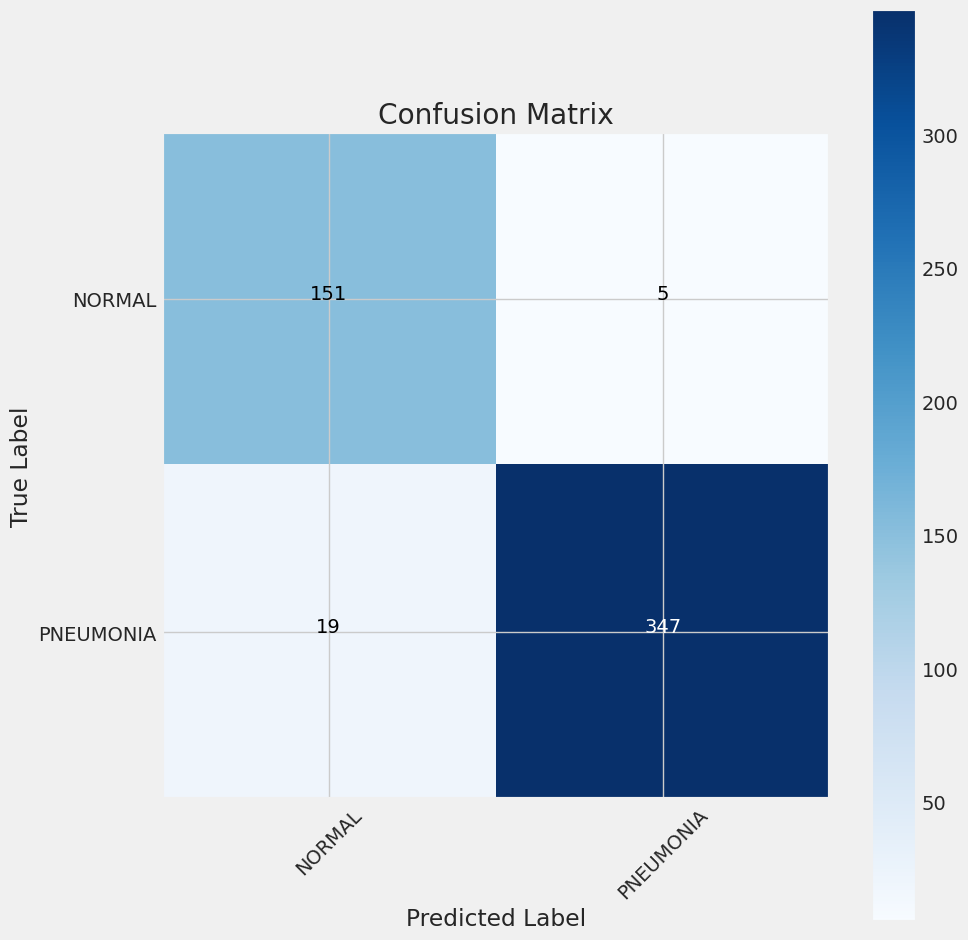

In [16]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
cm

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [17]:
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

      NORMAL       0.89      0.97      0.93       156
   PNEUMONIA       0.99      0.95      0.97       366

    accuracy                           0.95       522
   macro avg       0.94      0.96      0.95       522
weighted avg       0.96      0.95      0.95       522



In [ ]:
model.save("Pneumonia Detection.h5")
print("save model successful !")

In [ ]:
import h5py
f = h5py.File('Pneumonia_Detection.h5', 'r')
print(list(f.keys()))  